In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.utils.extmath import randomized_svd
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
def lev_score(A, k, eps):
    _, _, v_k = randomized_svd(A, k)
    pi = 1 / k * np.sum(v_k**2, axis=0)
    return pi

def COLUMNSELECT(A, k, eps):
    n = A.shape[1]
    c = k * np.log(k) / eps**2
    pi = lev_score(A, k, eps)
    c_index = [np.random.choice(2, p=[1 - min(1, c * pi[i]), min(1, c * pi[i])]) for i in range(n)]
    c_index = np.nonzero(c_index)[0]
    C = A[:, c_index]
    return C

def CUR_dec(A, k, eps):
    C = COLUMNSELECT(A, k, eps)
    R = COLUMNSELECT(np.transpose(A), k, eps).T
    U = np.linalg.pinv(C) @ A @ np.linalg.pinv(R)
    return C, U, R

# Loading and Preprocessing Data

In [3]:
%%time

df = pd.read_csv("ratings.csv" )
df_mat = df.pivot(index = "userId" , columns = "movieId", values = "rating")
df_mat = df_mat.fillna(0)
df.head()

CPU times: total: 93.8 ms
Wall time: 225 ms


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
%%time
matrix = df_mat.to_numpy()

CPU times: total: 0 ns
Wall time: 0 ns


# CUR Decomposition

### Error plot of CUR dependent of K

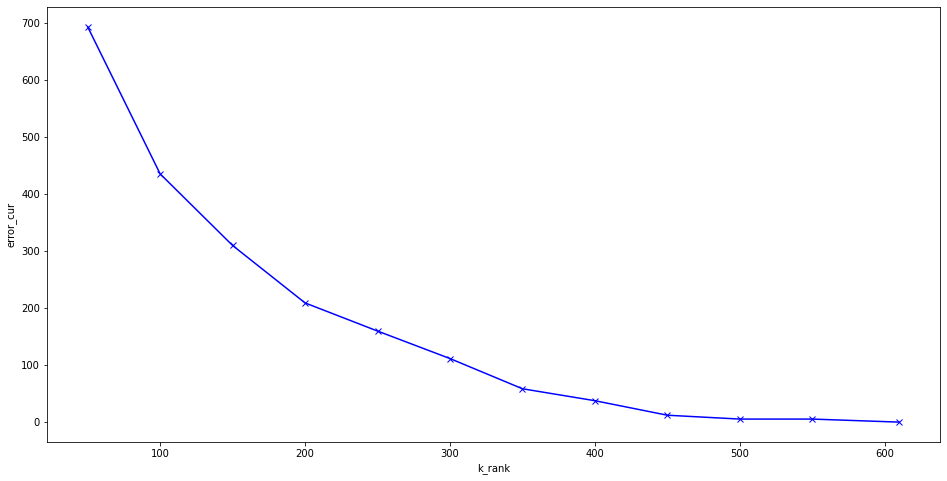

CPU times: total: 8min 33s
Wall time: 3min 7s


In [5]:
%%time
K = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 610]
error_cur = [ ]
for i in K:
    C, U, R = CUR_dec(matrix, i, 0.9)
    error_cur.append(np.linalg.norm(matrix - C@U@R))
plt.figure(figsize=(16,8))
plt.plot(K, error_cur, 'bx-')
plt.xlabel('k_rank')
plt.ylabel('error_cur')
plt.show()

In [6]:
%%time
C, U, R = CUR_dec(matrix, 28, 0.9)
A_k = C@U@R
error = np.linalg.norm(matrix - A_k)
print("The error in cur is", error)

The error in cur is 839.9642536612045
CPU times: total: 12.3 s
Wall time: 3.21 s


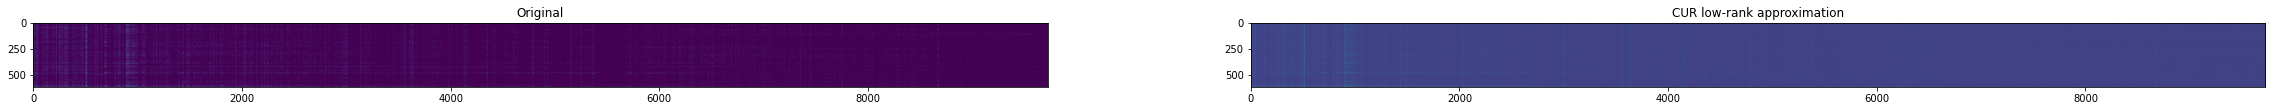

CPU times: total: 1.67 s
Wall time: 1.82 s


In [7]:
%%time
plt.figure(figsize=(40, 20))
plt.subplot(121)
plt.imshow(matrix)
plt.title('Original')
plt.subplot(122)
plt.imshow(C@U@R) 
plt.title('CUR low-rank approximation')

plt.show()

### Scatter plot of CUR

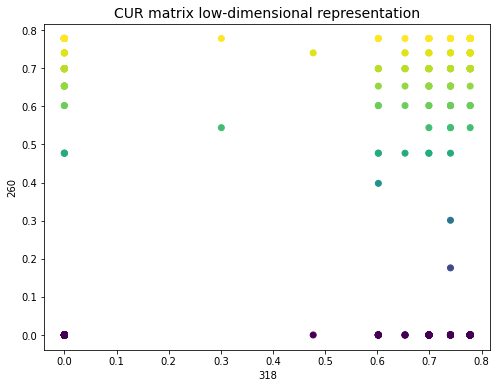

CPU times: total: 4.2 s
Wall time: 1.04 s


In [8]:
%%time
pi_col = lev_score(matrix, 28, 0.9)
Xlog = np.log10(df_mat + 1.0) #log expression data is more convenient to work
ids = np.argsort(pi_col)[::-1][:5]
fig, ax = plt.subplots(figsize=(8,6))
x1 = Xlog.iloc[:, ids[0]]
x2 = Xlog.iloc[:, ids[1]]
plt.scatter(x1, x2, c = x2)
plt.title('CUR matrix low-dimensional representation', fontsize=14)
plt.xlabel(x1.name)
plt.ylabel(x2.name)

plt.show()

### Scatter Plot of Projection Matrix

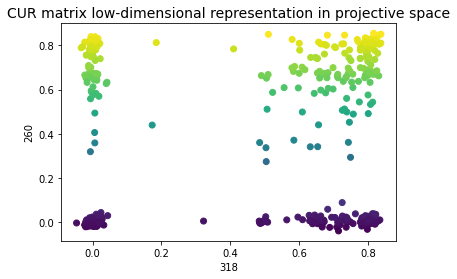

In [9]:
X_proj = C@np.linalg.pinv(C)@Xlog
x1 = X_proj.iloc[:, ids[0]]
x2 = X_proj.iloc[:, ids[1]]
plt.scatter(np.array(x1), np.array(x2), c = np.array(x2))
plt.title('CUR matrix low-dimensional representation in projective space', fontsize=14)
plt.xlabel(x1.name)
plt.ylabel(x2.name)

plt.show()

# Singular Value Decomposition

In [15]:
%%time
U_1, S, VT = np.linalg.svd(matrix, full_matrices=0)
S = np.diag(S)

CPU times: total: 7.53 s
Wall time: 6.41 s


### Error plot of SVD dependent of K

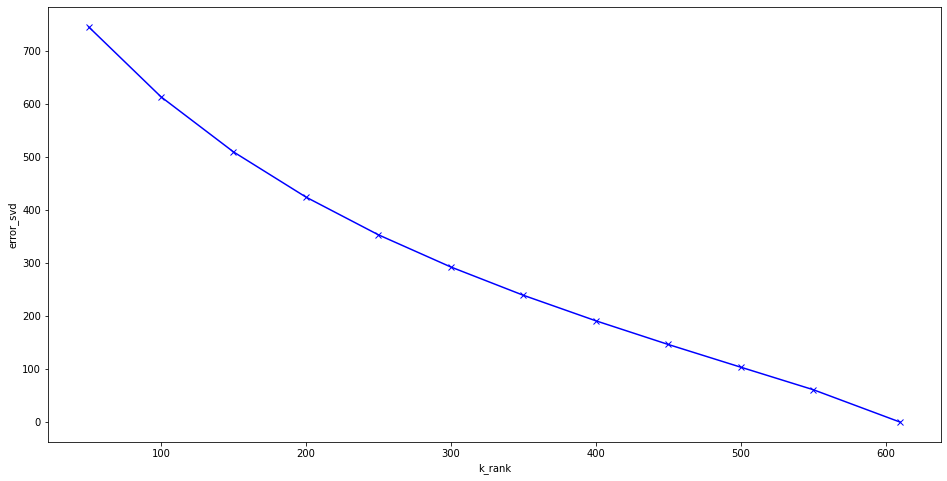

CPU times: total: 7.05 s
Wall time: 2.04 s


In [11]:
%%time
error_svd = []
for i in K:
    Xapprox = U_1[:, :i] @ S[0:i, :i] @ VT[:i,:]
    error_svd.append(np.linalg.norm(matrix - Xapprox))
plt.figure(figsize=(16,8))
plt.plot(K, error_svd, 'bx-')
plt.xlabel('k_rank')
plt.ylabel('error_svd')
plt.show()

In [12]:
%%time
r = 28
U_1, S, VT = np.linalg.svd(matrix, full_matrices=0)
S = np.diag(S)
Xapprox = U_1[:, :r] @ S[0:r, :r] @ VT[:r,:]
print('The error in svd is',np.linalg.norm(matrix - Xapprox))

The error in svd is 822.1182478939719
CPU times: total: 2.69 s
Wall time: 2.79 s


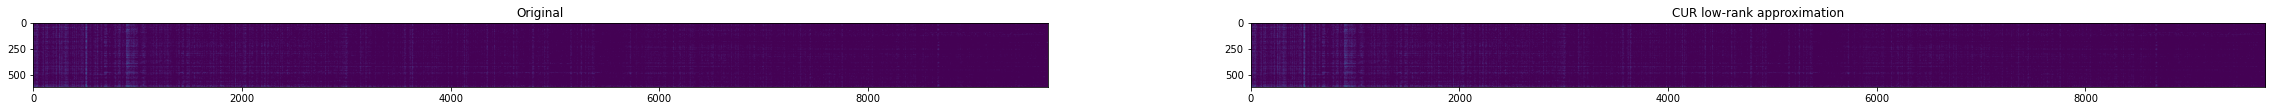

CPU times: total: 2.12 s
Wall time: 1.56 s


In [13]:
%%time
plt.figure(figsize=(40, 20))
plt.subplot(121)
plt.imshow(matrix)
plt.title('Original')
plt.subplot(122)
plt.imshow(U_1@S@VT) 
plt.title('CUR low-rank approximation')

plt.show()

### Scatter Plot of First two components of SVD

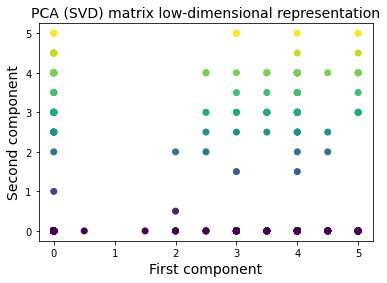

In [14]:
X_svd = (U_1@S@VT)[:,:]
plt.scatter(X_svd[:,0], X_svd[:,1], c = X_svd[:,1])
plt.title('PCA (SVD) matrix low-dimensional representation', fontsize=14)
plt.xlabel('First component', fontsize=14)
plt.ylabel('Second component', fontsize=14)
plt.show()